In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

from sklearn.linear_model import LinearRegression

import xgboost as xgb

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import json

from tqdm import tqdm_notebook as tqdm


## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_noninterp.feather")
se = se.set_index(se.columns[0])

In [3]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])



In [4]:
se['prev_timingPoint'] = se['prev_timingPoint'].astype(float).astype(int)

In [5]:
# se.iloc[1978]

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [8]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




## Adding in a few more medians... why not

Starting by making some more medians to compare

In [9]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

se['weekend'] = se['weekend'].astype(bool)

In [10]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

In [11]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [12]:
prev_stopCode_and_timing_point_groups = se[se["train"]].groupby(
    ["prev_stopCode", "prev_timingPoint"]
)

median_prev_dwell_by_prev_stop_code_and_timing_point = (
    prev_stopCode_and_timing_point_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_prev_stop_code_and_timing_point")
)

se = se.merge(
    median_prev_dwell_by_prev_stop_code_and_timing_point.to_frame(),
    "left",
    left_on=["prev_stopCode", "prev_timingPoint"],
    right_index=True,
)




In [13]:
segment_code_groups = se[se["train"]].groupby(
    ["segment_code"]
)

median_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code")
)

se = se.merge(
    median_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [14]:
se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_prev_dwell_by_segment_code_and_hour_and_daytype']



In [15]:
segment_code_and_hour_and_daytype_groups = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None
prev_stopCode_and_timing_point_groups = None
median_prev_dwell_by_prev_stop_code_and_timing_point = None
segment_code_groups = None
median_prev_dwell_by_segment_code = None


In [16]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min

In [17]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_", 
            "prev_stop_", 
            "next_stop_",
            "road"])

## Split dwell types into "normal" and not

There is a slight trick going on here. To know how early a bus is we must know it's actual arrival time. This won't be known in advance. So we'll have to estimate how early it's going to be in order to then estimate how long the dwell time is going to be? Is this too much of a hack? 🤔

In [18]:
se['prev_dwell_type_normal'] = True

In [19]:
# If it's a timing point and the bus is early (or even 20 seconds late) treat it as not normal

se.loc[(se['prev_timingPoint'] == 1) & (se['prev_actualArrival'] - pd.Timedelta("20 second") < se['prev_aimedArrival']), 'prev_dwell_type_normal'] = False

In [20]:
if 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal' in se.columns:
    se = se.drop(columns=['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'])

segment_code_and_hour_and_daytype_groups_normal = se[(se["train"] == True) & (se['prev_dwell_type_normal'] == True)].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_prev_dwell_by_segment_code_and_hour_and_daytype_normal = (
    segment_code_and_hour_and_daytype_groups_normal["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype_normal")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype_normal.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [21]:
#There are only 268 nan's just get rid of them. Should probably replace them with the normal median? 

se = se.dropna(subset=['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'])

### New feature how early the bus is to the stop

In [22]:
se['how_early'] = (se['prev_aimedArrival'] - se['prev_actualArrival']).astype('<m8[s]')

### Adding in if it's a merged stop

In [23]:
merged_stops = '{"1290BOB20387": ["167_16", "167_125", "167_18", "167_128", "167_21", "167_14", "167_127", "167_116", "167_2", "167_3", "167_115", "167_6", "167_117", "167_118", "167_1", "167_17", "167_15", "167_126", "167_124", "168_1", "168_2", "168_116", "168_3", "168_118", "168_6", "168_117", "168_115", "168_17", "168_126", "168_18", "168_15", "168_16", "168_125", "168_128", "168_21", "168_124", "168_127", "168_14"],"1290BOB20403": ["167_38", "167_44", "167_42", "167_135", "167_137", "167_40", "167_133", "167_134", "167_46", "167_37", "167_51", "167_36", "167_48", "167_23", "167_22", "167_26", "167_130", "167_24", "167_25", "167_28", "167_129", "167_33", "167_132", "167_31", "167_35", "167_32", "167_34", "167_131", "167_45", "167_136", "167_43", "167_41", "167_39", "168_24", "168_25", "168_26", "168_130", "168_22", "168_129", "168_28", "168_23", "168_33", "168_132", "168_35", "168_31", "168_32", "168_34", "168_131", "168_45", "168_43", "168_41", "168_136", "168_134", "168_46", "168_135", "168_137", "168_39", "168_37", "168_51", "168_48", "168_38", "168_40", "168_42", "168_44", "168_133", "168_36", "170_23", "170_22", "170_91", "170_21", "170_25", "170_20", "170_19", "170_90", "170_30", "170_93", "170_28", "170_31", "170_29", "170_92", "170_33", "170_35", "170_36", "170_34", "170_32"],"1280BOB20047": ["167_267", "167_265", "167_264", "167_266", "168_265", "168_264", "168_266", "168_267", "170_217", "170_215", "170_214", "170_216"],"1290BOB20402": ["167_284", "168_284", "170_236"]}'

In [24]:
merged_stops = json.loads(merged_stops)

In [25]:
se['merged_stop_prev'] = False

In [26]:
for stop, patterns in merged_stops.items():
    print(stop)
    print(len(patterns))
    
    se.loc[(se['prev_stopCode'] == stop) & (se['patternId'].isin(patterns)), 'merged_stop_prev'] = True

1290BOB20387
38
1290BOB20403
85
1280BOB20047
12
1290BOB20402
3


## Add a feature to see if it's the first stop of the day (we'll ignore those)

In [27]:
se['first_stop'] = False

In [28]:
firsts = se.reset_index().groupby(['vehicle', 'date']).first()

In [29]:
se.loc[firsts['index'], 'first_stop'] = True

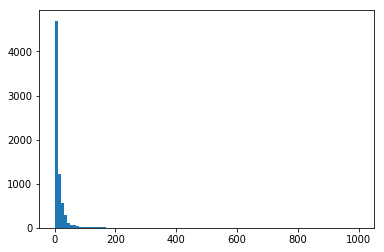

In [30]:
plt.hist(firsts['dwell_duration_prev'], bins=100, range=(0,1000));

In [31]:
np.count_nonzero(se['first_stop'])

7280

## Adding in the time gap (in seconds) between this bus and the previous and next buses

All based on the previous stop code

In [32]:
se_prev_stopCode_groups = se.groupby(["prev_stopCode"])

In [33]:
se['last_bus_gap'] = np.nan
se['next_bus_gap'] = np.nan

In [34]:
for name, stop in tqdm(se_prev_stopCode_groups):
    
    stop = stop.sort_values("prev_actualArrival")
    
    previous_bus = stop.shift(1)
    next_bus = stop.shift(-1)

    se.loc[stop.index, 'last_bus_gap'] = (stop['prev_actualArrival'] - previous_bus['prev_actualArrival']).astype('<m8[s]')
    se.loc[stop.index, 'next_bus_gap'] = (next_bus['prev_actualArrival'] - stop['prev_actualArrival']).astype('<m8[s]')
    

In [35]:
se = se.dropna(subset=['last_bus_gap', 'next_bus_gap'])
# se['next_bus_gap'] = se['next_bus_gap'].values.astype(float) * 1e-9

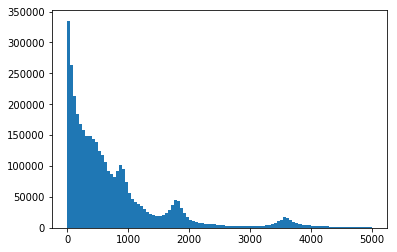

In [36]:
plt.hist(se['last_bus_gap'], bins=100, range=(0, 5000));

In [37]:
np.count_nonzero(np.isnan(se['last_bus_gap']))

0

In [38]:
np.count_nonzero(np.isnan(se['next_bus_gap']))

0

In [39]:
se['last_bus_recent'] = se['last_bus_gap'] < 30
se['next_bus_soon'] = se['next_bus_gap'] < 30

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
np.count_nonzero(np.isnan(se['next_bus_soon']))

0

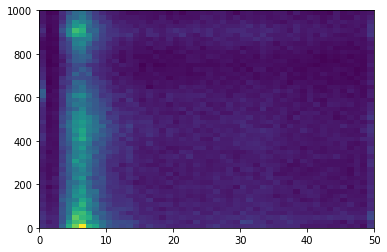

In [41]:
plt.hist2d(se.loc[~se['prev_dwell_type_normal'], 'dwell_duration_prev'], se.loc[~se['prev_dwell_type_normal'], 'next_bus_gap'], bins=[50,50], range=[[0,50],[0,1000]]);


In [122]:
se_prev_stopCode_rout_groups = se.groupby(["prev_stopCode", "publicName"])

se["last_this_bus_gap"] = np.nan
se["next_this_bus_gap"] = np.nan

for _, stop in tqdm(se_prev_stopCode_rout_groups):

    stop = stop.sort_values("prev_actualArrival")

    previous_bus = stop.shift(1)
    next_bus = stop.shift(-1)

    se.loc[stop.index, "last_this_bus_gap"] = (
        stop["prev_actualArrival"] - previous_bus["prev_actualArrival"]
    ).astype("<m8[s]")
    se.loc[stop.index, "next_this_bus_gap"] = (
        next_bus["prev_actualArrival"] - stop["prev_actualArrival"]
    ).astype("<m8[s]")

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [124]:
se = se.dropna(subset=['last_this_bus_gap', 'next_this_bus_gap'])

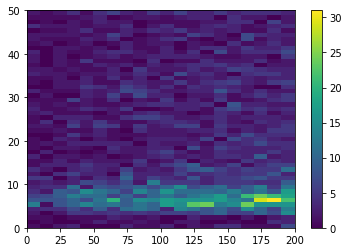

In [146]:
plt.hist2d(se.loc[~se['prev_dwell_type_normal'], "last_this_bus_gap"], se.loc[~se['prev_dwell_type_normal'], 'dwell_duration_prev'], bins=[20,50], range=[[0,200],[0,50]]);
plt.colorbar()

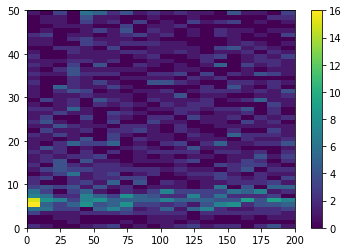

In [145]:
plt.hist2d(se.loc[~se['prev_dwell_type_normal'], "next_this_bus_gap"], se.loc[~se['prev_dwell_type_normal'], 'dwell_duration_prev'], bins=[20,50], range=[[0,200],[0,50]]);
plt.colorbar()

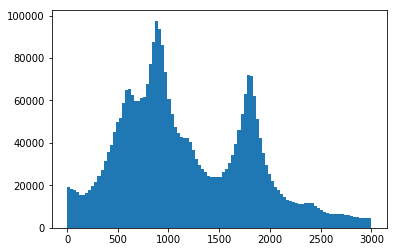

In [134]:
plt.hist(se['last_this_bus_gap'], bins=100, range=(0,3000));

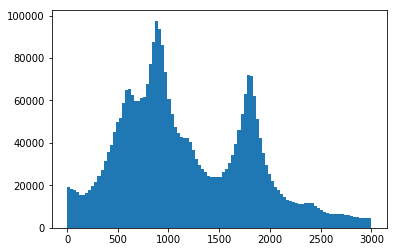

In [135]:
plt.hist(se['next_this_bus_gap'], bins=100, range=(0,3000));

## Making up some rules

In [42]:
early_timing_points = se[(se['prev_timingPoint'] == 1) & (se['prev_actualArrival'] + pd.Timedelta("1 minute") < se['prev_aimedArrival'])]

In [43]:
# How many dwell events are timing points and the bus arrives over a minute early

early_timing_points.shape[0]

75505

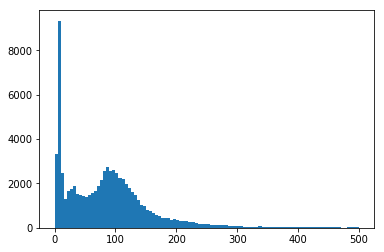

In [44]:
plt.hist(early_timing_points['dwell_duration_prev'], bins=100, range=(0,500));

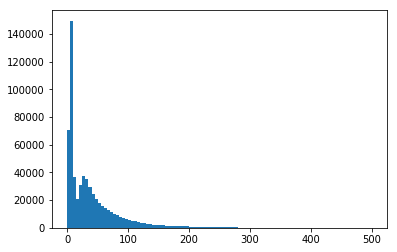

In [45]:
plt.hist(se.loc[se['prev_timingPoint'] == 1, 'dwell_duration_prev'], bins=100, range=(0,500));

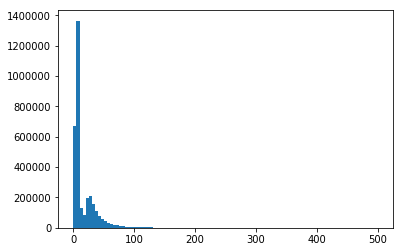

In [46]:
plt.hist(se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'], bins=100, range=(0,500));

# Looking at correlations between how early a timing point bus is and it's dwell time

In [118]:
buffers = []
median_dwells = []
mean_dwells = []
frequency = []

for extra in np.linspace(-120, +180, 31):
    dwells = se.loc[(se['prev_timingPoint'] == 1) & 
                    (se['how_early'] < extra + 10) &
                    (se['how_early'] > extra),
                        'dwell_duration_prev']
    
#     plt.hist(dwells, bins=100, range=(0,500));
#     plt.title(f"With {extra} seconds buffer")
#     plt.show()
    print(f"With {extra} seconds buffer")
    print(f"Length: {len(dwells):,}")
    print(f"Mean: {np.mean(dwells)}")
    print(f"Median: {np.median(dwells)}")
    print(f"----------------------------------")
    
    buffers.append(extra)
    median_dwells.append(np.median(dwells))
    mean_dwells.append(np.mean(dwells))
    frequency.append(len(dwells))
    
buffers = np.array(buffers).reshape(-1, 1) + 5
    

With -120.0 seconds buffer
Length: 9,441
Mean: 31.834763266603115
Median: 22.0
----------------------------------
With -110.0 seconds buffer
Length: 10,066
Mean: 31.38774090999404
Median: 21.0
----------------------------------
With -100.0 seconds buffer
Length: 10,802
Mean: 31.086095167561563
Median: 20.0
----------------------------------
With -90.0 seconds buffer
Length: 11,585
Mean: 30.48994389296504
Median: 19.0
----------------------------------
With -80.0 seconds buffer
Length: 12,796
Mean: 30.17700844013754
Median: 17.0
----------------------------------
With -70.0 seconds buffer
Length: 13,655
Mean: 30.783595752471623
Median: 17.0
----------------------------------
With -60.0 seconds buffer
Length: 15,060
Mean: 29.899003984063746
Median: 15.0
----------------------------------
With -50.0 seconds buffer
Length: 16,314
Mean: 28.6257815373299
Median: 12.0
----------------------------------
With -40.0 seconds buffer
Length: 18,747
Mean: 27.86941910705713
Median: 10.0
-------------

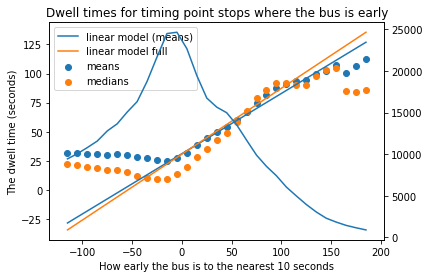

In [119]:


mean_dwells = np.array(mean_dwells)

plt.scatter(buffers, mean_dwells, label="means")
plt.scatter(buffers, median_dwells, label="medians")

reg = LinearRegression()

reg.fit(buffers[10:16], mean_dwells[10:16])

reg2 = LinearRegression()

fit_data = se.loc[(se['prev_timingPoint'] == 1) & 
                    (se['how_early'] < 100) &
                    (se['how_early'] > -20),
                        ['how_early', 'dwell_duration_prev']].values

reg2.fit(fit_data[:,0].reshape(-1, 1), fit_data[:,1])



plt.plot(buffers, reg.predict(buffers), label="linear model (means)")
plt.plot(buffers, reg2.predict(buffers), label="linear model full")

plt.legend()
plt.title("Dwell times for timing point stops where the bus is early")
plt.xlabel("How early the bus is to the nearest 10 seconds")
plt.ylabel("The dwell time (seconds)")

ax = plt.gca()

ax2 = ax.twinx()

ax2.plot(buffers, frequency)
plt.show()

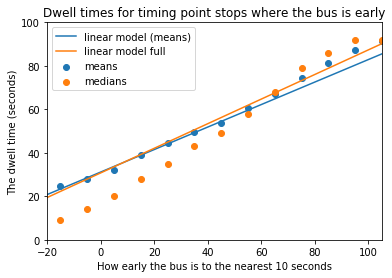

In [120]:
mean_dwells = np.array(mean_dwells)

plt.scatter(buffers, mean_dwells, label="means")
plt.scatter(buffers, median_dwells, label="medians")

plt.plot(buffers, reg.predict(buffers), label="linear model (means)")
plt.plot(buffers, reg2.predict(buffers), label="linear model full")

plt.legend()
plt.title("Dwell times for timing point stops where the bus is early")
plt.xlabel("How early the bus is to the nearest 10 seconds")
plt.ylabel("The dwell time (seconds)")
plt.xlim(-20,105)
plt.ylim(0,100)

plt.show()

### Doing the same test with non-timing points

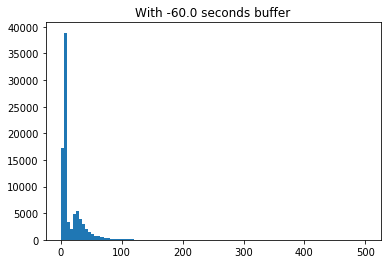

With -60.0 seconds buffer
Length: 87,350
Mean: 16.137321121923296
Median: 6.0
----------------------------------


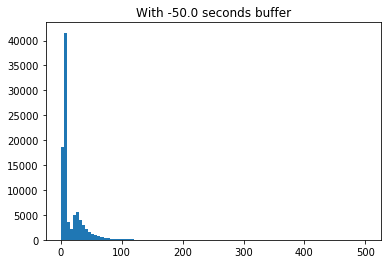

With -50.0 seconds buffer
Length: 92,812
Mean: 16.050209024695082
Median: 6.0
----------------------------------


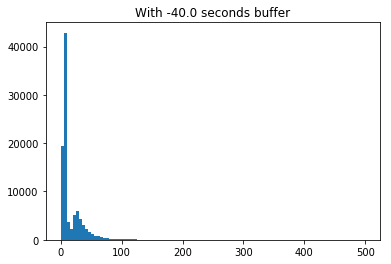

With -40.0 seconds buffer
Length: 96,107
Mean: 16.078610298937644
Median: 6.0
----------------------------------


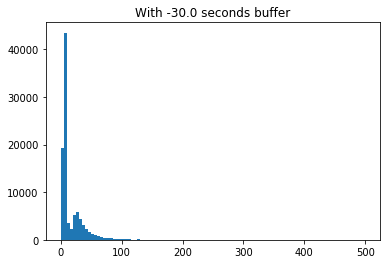

With -30.0 seconds buffer
Length: 96,761
Mean: 16.190262605801923
Median: 6.0
----------------------------------


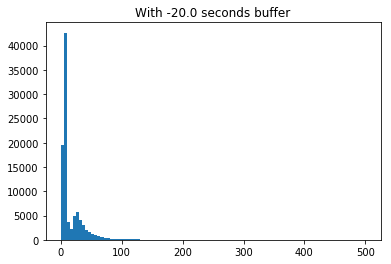

With -20.0 seconds buffer
Length: 95,338
Mean: 16.14499989511003
Median: 6.0
----------------------------------


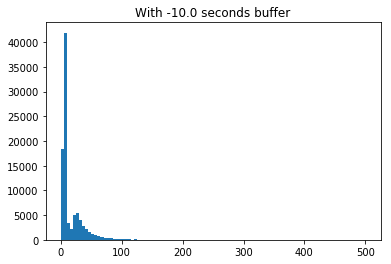

With -10.0 seconds buffer
Length: 92,518
Mean: 16.196761711234572
Median: 6.0
----------------------------------


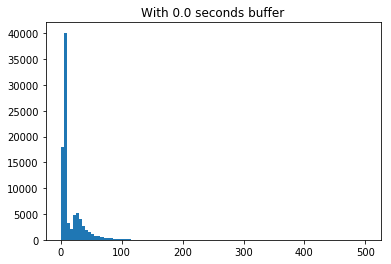

With 0.0 seconds buffer
Length: 88,644
Mean: 16.073022426785794
Median: 6.0
----------------------------------


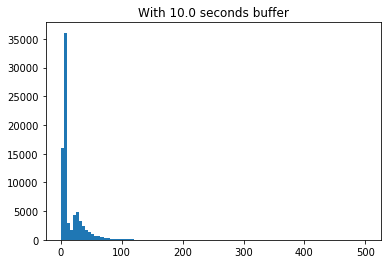

With 10.0 seconds buffer
Length: 79,597
Mean: 16.31492392929382
Median: 6.0
----------------------------------


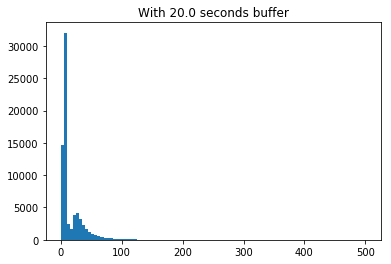

With 20.0 seconds buffer
Length: 71,788
Mean: 16.783181033041735
Median: 6.0
----------------------------------


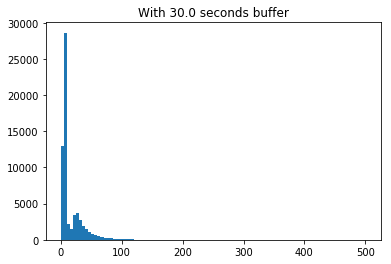

With 30.0 seconds buffer
Length: 64,090
Mean: 16.929084100483696
Median: 6.0
----------------------------------


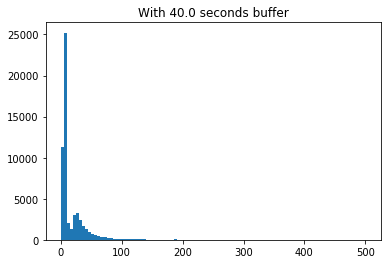

With 40.0 seconds buffer
Length: 56,669
Mean: 17.45815172316434
Median: 6.0
----------------------------------


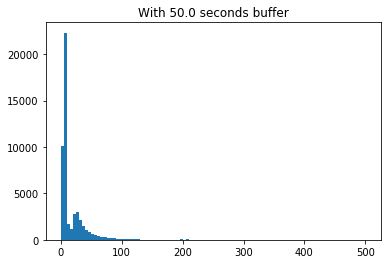

With 50.0 seconds buffer
Length: 50,378
Mean: 17.64403112469729
Median: 6.0
----------------------------------


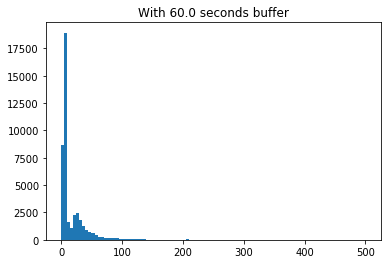

With 60.0 seconds buffer
Length: 42,905
Mean: 17.939820533737326
Median: 6.0
----------------------------------


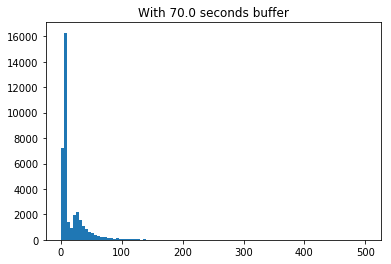

With 70.0 seconds buffer
Length: 36,840
Mean: 18.085124864277958
Median: 6.0
----------------------------------


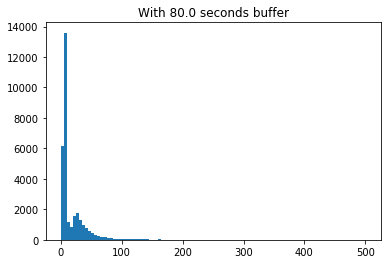

With 80.0 seconds buffer
Length: 31,132
Mean: 18.603045098291147
Median: 6.0
----------------------------------


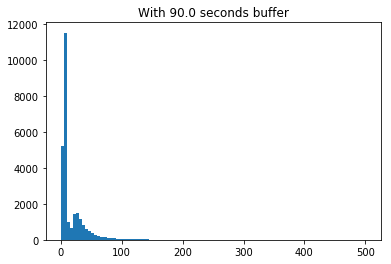

With 90.0 seconds buffer
Length: 26,510
Mean: 18.565711052433045
Median: 6.0
----------------------------------


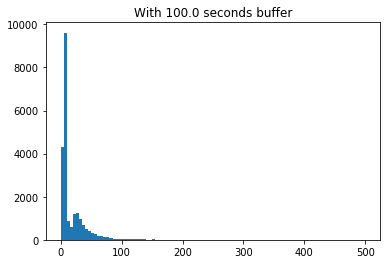

With 100.0 seconds buffer
Length: 22,256
Mean: 19.147960100647015
Median: 6.0
----------------------------------


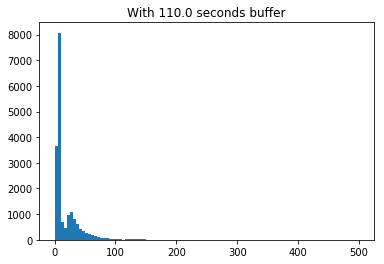

With 110.0 seconds buffer
Length: 18,689
Mean: 18.89999464925892
Median: 6.0
----------------------------------


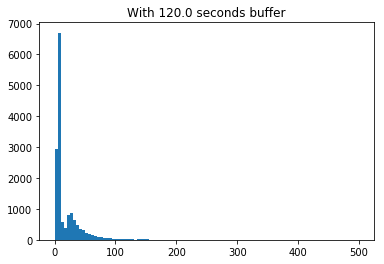

With 120.0 seconds buffer
Length: 15,363
Mean: 19.113975135064766
Median: 6.0
----------------------------------


In [73]:
buffers = []
median_dwells = []
mean_dwells = []

for extra in np.linspace(-60, +120, 19):
    dwells = se.loc[(se['prev_timingPoint'] == 0) & 
                    (se['how_early'] < extra + 10) &
                    (se['how_early'] > extra),
                        'dwell_duration_prev']
    
    plt.hist(dwells, bins=100, range=(0,500));
    plt.title(f"With {extra} seconds buffer")
    plt.show()
    print(f"With {extra} seconds buffer")
    print(f"Length: {len(dwells):,}")
    print(f"Mean: {np.mean(dwells)}")
    print(f"Median: {np.median(dwells)}")
    print(f"----------------------------------")
    
    buffers.append(extra)
    median_dwells.append(np.median(dwells))
    mean_dwells.append(np.mean(dwells))
    

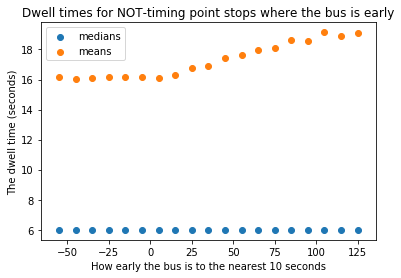

In [74]:
buffers = np.array(buffers).reshape(-1, 1) + 5

plt.scatter(buffers, median_dwells, label="medians")
plt.scatter(buffers, mean_dwells, label="means")

plt.legend()
plt.title("Dwell times for NOT-timing point stops where the bus is early")
plt.xlabel("How early the bus is to the nearest 10 seconds")
plt.ylabel("The dwell time (seconds)")
plt.show()

### So we have a plan. 
- For all non-timing point dwells we do the normal thing (median per stop/segment, hour of the day and day type)
- For all timing points that are late we do ~~normal~~ something else?...
- For all timing points that are early between 0 and 90 seconds we do a linear prediction
- For all timing points beyond 90 seconds late we predict 90 seconds
- Easy when you know how... :) 

### This means that we should only train on "normal and early stops"

### Looking at some MAPEs

In [50]:
# Just doing our normal approach is OK...

MAPE(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], se['dwell_duration_prev'])

84.54851461528679

In [51]:
# But works much better for non-timing points.

MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])

73.74510870342984

In [52]:
# At first this is a confusing result but actually it's expected because all 
# non-timing points are their own segment code so their values are the same 
# in either case

MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])

73.74510870342984

In [53]:
# Extending this to all normal dwells makes it quite a bit worse but still better then before. 

MAPE(se.loc[se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_dwell_type_normal'], 'dwell_duration_prev'])


78.70939598634187

In [54]:
MAPE([4] * se.shape[0], se['dwell_duration_prev'])

54.60456057059473

In [55]:
for i in np.linspace(4.99,5.01,21):
    print(f"guess: {i}, Mape: {MAPE([i] * se.shape[0], se['dwell_duration_prev'])}")

guess: 4.99, Mape: 52.53496786556488
guess: 4.9910000000000005, Mape: 52.532877367883124
guess: 4.992, Mape: 52.53078687020123
guess: 4.993, Mape: 52.52869637251943
guess: 4.994, Mape: 52.52660587483761
guess: 4.995, Mape: 52.52451537715567
guess: 4.996, Mape: 52.52242487947385
guess: 4.997, Mape: 52.520334381792026
guess: 4.998, Mape: 52.51824388411016
guess: 4.999, Mape: 52.51615338642836
guess: 5.0, Mape: 52.51406288874646
guess: 5.001, Mape: 52.51830074562595
guess: 5.002, Mape: 52.52253860250535
guess: 5.003, Mape: 52.526776459384756
guess: 5.004, Mape: 52.53101431626414
guess: 5.005, Mape: 52.53525217314359
guess: 5.006, Mape: 52.539490030023074
guess: 5.007, Mape: 52.543727886902474
guess: 5.008, Mape: 52.54796574378186
guess: 5.0089999999999995, Mape: 52.55220360066134
guess: 5.01, Mape: 52.55644145754076


In [56]:
# When tested on only test data ther results are still better than including the non-normal events

MAPE(se.loc[se['test'] & se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['test'] & se['prev_dwell_type_normal'], 'dwell_duration_prev'])



82.83096874092175

In [57]:
MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])


73.74510870342984

In [58]:
# Unfortunatly this linear model actually does really poorly when used in the real world.
# This is probably because of the shape of the distribution, actually prediting the median
# Works really badly as very little mass is in the middle, it's double humped.

earlies = se.loc[se['prev_dwell_type_normal'] == False, 'how_early'].values.reshape(-1, 1)


MAPE(reg.predict(earlies), se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'])


254.45125319364436

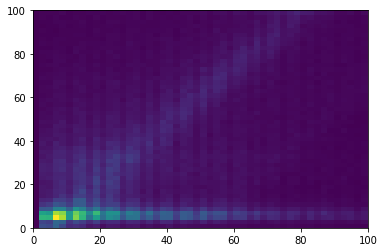

In [59]:
plt.hist2d(reg.predict(earlies), se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'], bins=[50,50], range=[[0,100],[0,100]]);

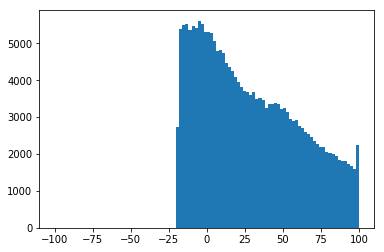

In [60]:
plt.hist(earlies, bins=100, range=(-100,100));

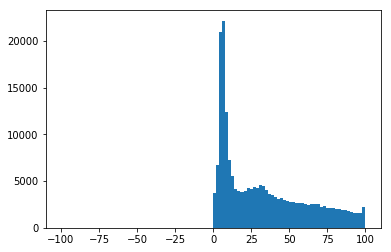

In [61]:
plt.hist(se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'], bins=100, range=(-100,100));

## Trying a richer Linear model

In [62]:
# Remove most of the features and then put back a few we want

for_xg = exclude_columns_containing(se, ["id", 
                                         "date", 
                                         "stopCode", 
                                         "aimed", 
                                         "actual", 
                                         "workid", 
                                         "patternId", 
                                         "publicName", 
                                         "segment_code", 
                                         "segment_name", 
                                         "arrival_5mins",
                                         "full_duration",
                                         "segment_duration",
                                         "dwell",
                                         "self_offset"])

for_xg['median_durations_by_segment_code_and_hour_and_day'] = se['median_durations_by_segment_code_and_hour_and_day']

for_xg['median_prev_dwell_by_segment_code_and_hour_and_daytype'] = se['median_prev_dwell_by_segment_code_and_hour_and_daytype']

for_xg['median_full_durations_by_segment_code_and_hour_and_day'] = se['median_full_durations_by_segment_code_and_hour_and_day']

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [63]:
for_xg.columns

Index(['vehicle', 'scheduledStart', 'timingPoint', 'prev_timingPoint',
       'line_distance', 'to_centre_dist', 'direction', 'direction_degrees',
       'train', 'test', 'rain', 'arrival_hour', 'arrival_day',
       'clock_direction_degrees', 'dry', 'weekend', 'how_early',
       'merged_stop_prev', 'first_stop', 'last_bus_gap', 'next_bus_gap',
       'last_bus_recent', 'next_bus_soon',
       'median_durations_by_segment_code_and_hour_and_day',
       'median_prev_dwell_by_segment_code_and_hour_and_daytype',
       'median_full_durations_by_segment_code_and_hour_and_day'],
      dtype='object')

In [64]:
reg = LinearRegression()

reg.fit(for_xg[for_xg['train'] & (se['prev_dwell_type_normal'] == False)], se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], 'dwell_duration_prev'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [65]:
lin_reg_results = reg.predict(for_xg[se['test'] & (se['prev_dwell_type_normal'] == False)])

MAPE(lin_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

263.54612751009375

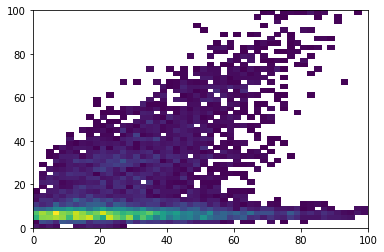

In [66]:
plt.hist2d(lin_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'], bins=[50,50], range=[[0,100],[0,100]], cmin=10);


Linear is still rubbish. In fact just predicting the overal median does slightly better

In [67]:
MAPE([se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], "dwell_duration_prev"].median()] * se.loc[(se['prev_dwell_type_normal'] == False) & se['test']].shape[0],se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

210.59346274395807

## Prediciting special dwell times with XGBoost


In [68]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=3, max_depth=6, n_estimators=1, verbosity=1)

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=3, n_estimators=10, verbosity=1)

xg_reg.fit(for_xg[for_xg['train'] & (se['prev_dwell_type_normal'] == False)], se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], 'dwell_duration_prev'])

xg_reg.save_model("xg_model_timing_points")

# xg_reg.load_model("models 75days/xg_model_xgboost")

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields weekend

In [ ]:
xg_reg_results = xg_reg.predict(for_xg[se['test'] & (se['prev_dwell_type_normal'] == False)])


In [ ]:
MAPE(xg_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

In [ ]:
plt.hist2d(xg_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'], bins=[25,25], range=[[0,120],[-200,2000]], cmin=10);


In [ ]:
plt.scatter(xg_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

In [ ]:
feature_importances = xg_reg.feature_importances_

features_sorted = np.argsort(feature_importances)

for i in range(for_xg.shape[1]):
    print(f"{for_xg.columns[features_sorted[i]]} -> {feature_importances[features_sorted[i]]}")

In [ ]:
plt.hist(xg_reg_results, bins=50, range=(0,10));

In [ ]:
MAPES = []

for i in range(1, 25):
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=i, n_estimators=1, verbosity=1)

    # xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=3, n_estimators=10, verbosity=1)

    xg_reg.fit(for_xg[for_xg['train'] & (se['prev_timingPoint'] == 1)], se.loc[(se['prev_timingPoint'] == 1) & se['train'], 'dwell_duration_prev'])

    xg_reg_results = xg_reg.predict(for_xg[se['test'] & (se['prev_timingPoint'] == 1)])
    
    mape = MAPE(xg_reg_results, se.loc[(se['prev_timingPoint'] == 1) & se['test'], 'dwell_duration_prev'])
    
    MAPES.append(mape)

    print(f"i:{i} -> MAPE: {mape}")

In [ ]:
plt.plot(range(1,25), MAPES)

In [ ]:
for extra in np.linspace(-20, +100, 13):
    dwells = se.loc[(se['prev_dwell_type_normal'] == False) & 
                    (se['how_early'] < extra + 10) &
                    (se['how_early'] > extra),
                        'dwell_duration_prev']
    
    plt.hist(dwells, bins=100, range=(0,500));
    plt.title(f"With {extra} seconds buffer")
    plt.show()

    rows = for_xg[(for_xg['how_early'] < extra + 10) & (for_xg['how_early'] > extra)]
    
    preds = xg_reg.predict(rows)

    plt.hist(preds, bins=100, range=(0,500), color='red');
    plt.title(f"With {extra} seconds buffer, preds")
    plt.show()
    

It's basically just predicting the spike at the begining. Rubbish. This means it doesn't have enough data to do better. Can we add some? 

## Trying a random forest

In [ ]:
rf_reg = xgb.XGBRegressor(
        objective="reg:linear",
        eval_metric="mae",
        booster="gbtree",
        n_jobs=5,
        max_depth=3,
        verbosity=2,
        colsample_bynode=0.8,
        learning_rate=1,
        num_parallel_tree=10,
        subsample=0.8,
        tree_method="hist",
    )

In [ ]:
rf_reg.fit(for_xg[for_xg['train'] & (se['prev_dwell_type_normal'] == False)], se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], 'dwell_duration_prev'])

rf_reg.save_model("rf_model_timing_points")



In [ ]:
rf_reg_results = rf_reg.predict(for_xg[se['test'] & (se['prev_dwell_type_normal'] == False)])

In [ ]:
MAPE(rf_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

In [ ]:
feature_importances = rf_reg.feature_importances_

features_sorted = np.argsort(feature_importances)

for i in range(for_xg.shape[1]):
    print(f"{for_xg.columns[features_sorted[i]]} -> {feature_importances[features_sorted[i]]}")

In [96]:
se.columns

Index(['id', 'date', 'stopCode', 'aimedArrival', 'aimedDeparture',
       'actualArrival', 'actualDeparture', 'vehicle', 'workid', 'patternId',
       'publicName', 'scheduledStart', 'prev_stopCode', 'prev_aimedArrival',
       'prev_aimedDeparture', 'prev_actualArrival', 'prev_actualDeparture',
       'timingPoint', 'prev_timingPoint', 'segment_code', 'segment_name',
       'line_distance', 'midpoint_lat', 'midpoint_lon', 'to_centre_dist',
       'direction', 'direction_degrees', 'train', 'test', 'rain',
       'dwell_duration_dest', 'dwell_duration_prev', 'segment_duration',
       'timetable_segment_duration', 'full_duration', 'arrival_hour',
       'arrival_day', 'mean_durations_by_segment_code',
       'mean_durations_by_segment_code_and_hour',
       'mean_durations_by_segment_code_and_hour_and_day',
       'mean_dwell_dest_durations_by_stop_code',
       'mean_dwell_prev_durations_by_stop_code',
       'mean_dwell_dest_by_stop_code_and_hour',
       'mean_dwell_prev_by_stop_code